# Case 3. Heart Disease Classification 
    Cognitive Systems for Health Technology Applications
    19.3.2019, Emil Rantanen ja Wille Tuovinen
    Metropolia University of Applied Sciences

This is the code made for the Case 3 Exercise of the Cognitive Systems for Health Technology applications. 

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import pyplot, pylab
plt = pyplot
%matplotlib inline

df = pd.read_csv('A:/Downloads/Case3/drugsComTrain_raw.csv')
dfTest = pd.read_csv('A:/Downloads/Case3/drugsComTest_raw.csv')
df.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [2]:
dfTest.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,3-Jul-14,13
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,21-Apr-09,32
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,18-Oct-16,21
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,16-Apr-11,3


In [3]:
# Are the columns same in train and test sets?
list(df) == list(dfTest)

True

In [4]:
# How many rows are there in train and test sets?
rows_train = df.values.shape[0]
rows_test = dfTest.values.shape[0]
print('Rows in train set:', rows_train)
print('Rows in test set:', rows_test)

# What is the ratio of the train and test set sizes?
ratio = rows_train/rows_test
print('Ratio (train:test) = {:.3f}'.format(ratio))

Rows in train set: 161297
Rows in test set: 53766
Ratio (train:test) = 3.000


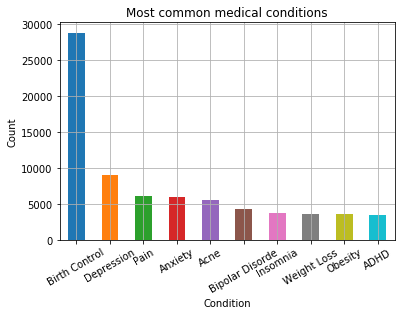

In [5]:
df['condition'].value_counts().sort_values(ascending=False)[:10].plot(kind='bar', rot = 30)
plt.title('Most common medical conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.grid()
plt.show()

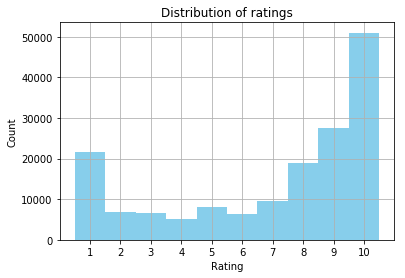

In [6]:
# How are the ratings distributed?
df['rating'].hist(color='skyblue', bins = range(1, 12), align = 'left')
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 11))
plt.show()

In [7]:
# Import natural language processing toolkit
import nltk
nltk.download('vader_lexicon')
# Use the VADER sentiment analysis tools.
# Ref. Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. 
# Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
# http://www.nltk.org/api/nltk.sentiment.html
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to C:\Users\Milin
[nltk_data]     Pelipaja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
# Analyze the sentiment polarity of each review with scale -1.0 ... +1.0
# Takes a long time...
sid = SentimentIntensityAnalyzer()
sentiments = []
for r in df['review']:
    sentiments.append(sid.polarity_scores(r).get('compound')) 
sentiments = np.asarray(sentiments)
# Check the first 10 values
sentiments[:10]

array([-0.296 ,  0.8603,  0.7645,  0.7184,  0.9403, -0.4342,  0.    ,
       -0.9468, -0.5593, -0.901 ])

In [9]:
useful_df = df.sort_values(by='usefulCount', ascending=False)

# Add the sentiment polarity analysis to dataframe
useful_df['sentiment'] = pd.Series(data=sentiments)

# Reset the indexing and display the first 10 rows
useful_df = useful_df.reset_index(drop=True)
useful_df.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291,0.9772
1,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291,0.9772
2,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247,0.7739
3,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247,0.7739
4,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949,-0.6815
5,139141,Phentermine,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796,0.7921
6,52305,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796,0.7921
7,62757,Citalopram,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771,-0.7227
8,89825,Celexa,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771,-0.7227
9,107655,Implanon,Birth Control,"""I was very nervous about trying Implanon afte...",10,19-Jul-10,730,-0.9375


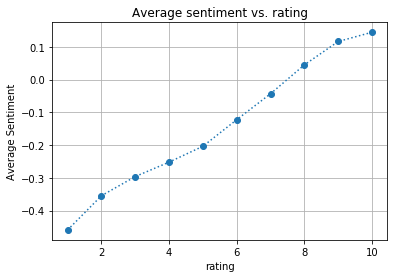

In [10]:
# What is the average sentiment vs. rating?
useful_df.groupby('rating')['sentiment'].mean().plot(style = 'o:')
plt.ylabel('Average Sentiment')
plt.title('Average sentiment vs. rating')
plt.grid()
plt.show()

In [11]:
# Import libraries
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [12]:
# Creates TF-IDF vectorizer and transforms the corpus
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df['review'].iloc[:10000])

# transforms test reviews to above vectorized format
X_test = vectorizer.transform(dfTest['review'].iloc[:5000])

In [13]:
# Create a column with binary rating indicating the polarity of a review
df['binary_rating'] = df['rating'] > 5
y_train_rating = df['binary_rating'].iloc[:10000]

dfTest['binary_rating'] = dfTest.rating > 5
y_test_rating = dfTest['binary_rating'].iloc[:5000]

In [14]:
# Use Naive Bayes classifier
clf = MultinomialNB().fit(X_train, y_train_rating)

# Evaluate the model
pred = clf.predict(X_test)

print("Accuracy: {:.3f}".format(clf.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Accuracy: 0.702
Confusion Matrix
[[  18    1]
 [1489 3492]]


In [15]:
# Use random forest classifier
start = time.time()
rfc_rating = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = 10000, min_samples_split = 0.001)
rfc_rating.fit(X_train, y_train_rating)
end = time.time()
print("Training time: {:.0f} seconds.".format(end-start))

# Evaluate the model
pred = rfc_rating.predict(X_test)

print("Accuracy: {:.3f}".format(rfc_rating.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Training time: 6 seconds.
Accuracy: 0.747
Confusion Matrix
[[ 275   31]
 [1232 3462]]


In [16]:
from keras.preprocessing.text import Tokenizer

samples = df['review'].iloc[:15000]
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 20153 unique tokens.


In [17]:
# Make one hot samples
data = tokenizer.texts_to_matrix(samples, mode='binary')
data.shape

(15000, 5000)

In [18]:
# Show the first data row
data[:1]

array([[0., 1., 1., ..., 0., 0., 0.]])

In [19]:
# Create binary labels:
# label = 1, when rating > 5
# label = 0, otherwise
labels = (df['rating'].iloc[:15000].values > 5)
labels[:10]

array([ True,  True, False,  True,  True, False, False,  True, False,
        True])

In [20]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size = 0.333, random_state = 2019)

In [21]:
# Create a simple sequential model
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(256, input_dim = 5000))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1280256   
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 1,288,513
Trainable params: 1,288,513
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(x_train, y_train, 
                    epochs = 10, 
                    batch_size = 32,
                    verbose = 1,
                    validation_data = (x_val, y_val))

Train on 10005 samples, validate on 4995 samples
Epoch 1/10
10005/10005 [==============================] - 12s 1ms/step - loss: 0.4629 - acc: 0.7855 - val_loss: 0.4503 - val_acc: 0.8070
Epoch 2/10
10005/10005 [==============================] - 2s 209us/step - loss: 0.3119 - acc: 0.8713 - val_loss: 0.5007 - val_acc: 0.8032
Epoch 3/10
10005/10005 [==============================] - 2s 210us/step - loss: 0.1998 - acc: 0.9252 - val_loss: 0.6182 - val_acc: 0.8064
Epoch 4/10
10005/10005 [==============================] - 2s 211us/step - loss: 0.1078 - acc: 0.9644 - val_loss: 0.6917 - val_acc: 0.8088
Epoch 5/10
10005/10005 [==============================] - 2s 213us/step - loss: 0.0499 - acc: 0.9856 - val_loss: 0.8489 - val_acc: 0.8112
Epoch 6/10
10005/10005 [==============================] - 2s 207us/step - loss: 0.0197 - acc: 0.9950 - val_loss: 1.0708 - val_acc: 0.8032
Epoch 7/10
10005/10005 [==============================] - 2s 209us/step - loss: 0.0090 - acc: 0.9982 - val_loss: 1.3199 - va

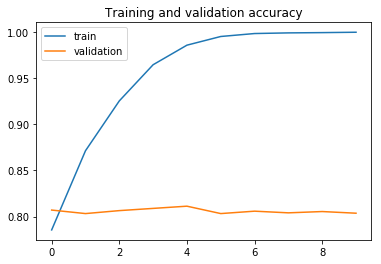

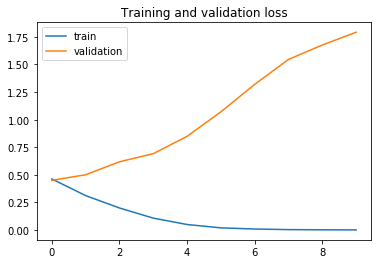

In [23]:
# Plot the accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, label = 'train')
plt.plot(val_acc, label = 'validation')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(loss, label = 'train')
plt.plot(val_loss, label = 'validation')
plt.title('Training and validation loss')
plt.legend()

plt.show()